In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def run_flan_encode_decode(input_ids):
    encoder_outputs = model.encoder(input_ids)
    decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
    return model.decoder(
        input_ids=decoder_input_ids,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
    )

In [7]:
from lrp_engine import LRPEngine, checkpoint_hook

In [8]:
lrp = LRPEngine()

In [9]:
prompt = "'Welcome to the final examination for this term's offering of CS100. Please remove all headphones and earbuds, as well as hats and hoods. Place your bag under your desk so that it does not block the aisle. You are permitted writing instruments, a clear water bottle, and any aids listed on the front of your booklet. The exam will be 150 minutes in duration. You may now begin.' How long is the exam?"
input_ids = tokenizer(prompt, return_tensors="pt").to(device)["input_ids"]

In [10]:
decoder_outputs = run_flan_encode_decode(input_ids)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [11]:
_, param_vals = lrp.run(decoder_outputs.last_hidden_state)

In [12]:
_, param_vals1 = lrp.run(decoder_outputs.last_hidden_state)

In [13]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((p1 - p0)**2).sum() for p1, p0 in zip(param_vals1, param_vals)
]

[tensor(7.4446e-24, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(2.4216e-24, device='cuda:0'),
 tensor(1.4050e-22, device='cuda:0')]

In [14]:
[ t.shape for t in param_vals ]

[torch.Size([1, 1]),
 torch.Size([1, 1]),
 torch.Size([1, 103]),
 torch.Size([103, 103])]

150.</s>CS duration
torch.return_types.topk(
values=tensor([[4.1885e-06, 1.9502e-06, 1.3920e-06, 1.1044e-06, 9.6613e-07]],
       device='cuda:0'),
indices=tensor([[ 85,  80, 102,  18,  88]], device='cuda:0'))


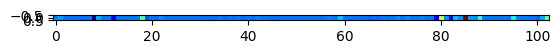

In [15]:
from matplotlib import pyplot as plt

plt.imshow(param_vals1[2].cpu(), cmap="jet")

print(tokenizer.decode(input_ids[0][param_vals1[2].topk(5).indices][0]))
print(param_vals1[2].topk(5))

In [16]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")

In [17]:
max_length = 0
for example in dataset["validation"].select(range(100)):
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]

    input_ids = tokenizer(context + " " + question, return_tensors="pt")["input_ids"]

    if input_ids.shape[-1] > max_length:
        max_length = input_ids.shape[-1]
print(max_length)

461


In [17]:
from tqdm import tqdm

results = []
top1_hits = 0
total_examples = 0

for example in tqdm(dataset["validation"]):
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]

    if not answers:
        continue

    input_ids = tokenizer(context + " " + question, return_tensors="pt")["input_ids"].to(device)
    if input_ids.shape[-1] > 512:
        continue
    
    output = run_flan_encode_decode(input_ids)

    _, param_vals = lrp.run(output.last_hidden_state)

    lrp_max = param_vals[2].flatten().argmax()
    lrp_top_token = tokenizer.convert_ids_to_tokens([input_ids[0][lrp_max]])[0].strip().replace(chr(9601), "")

    if any(lrp_top_token in ans for ans in answers):
        top1_hits += 1
    total_examples += 1
    if not (total_examples % 100):
        print(top1_hits, total_examples)
    # lrp_top5 = param_vals[2].flatten().topk(k=5)
    # lrp_top5_tokens = tokenizer.decode(input_ids[0][lrp_top5.indices.cpu()])
    # results.append({
    #     "example": example,
    #     "lrp_top5_tokens": lrp_top5_tokens,
    #     "lrp_top5_relevances": lrp_top5.values.cpu(),
    #     "is_impossible": len(answers) == 0
    # })

  2%|█▍                                                                            | 217/11873 [01:01<46:50,  4.15it/s]

82 100


  4%|██▊                                                                           | 427/11873 [02:00<41:03,  4.65it/s]

153 200


  5%|████                                                                        | 636/11873 [03:01<1:00:17,  3.11it/s]

222 300


  7%|█████▎                                                                        | 815/11873 [04:01<45:39,  4.04it/s]

306 400


  8%|██████▍                                                                      | 1002/11873 [05:00<59:35,  3.04it/s]

381 500


 10%|███████▌                                                                   | 1193/11873 [06:02<1:07:04,  2.65it/s]

461 600


 12%|████████▊                                                                  | 1392/11873 [07:02<1:10:24,  2.48it/s]

535 700


 13%|██████████▎                                                                  | 1592/11873 [08:03<39:28,  4.34it/s]

613 800


 15%|███████████▌                                                                 | 1786/11873 [09:04<51:51,  3.24it/s]

692 900


 17%|████████████▉                                                                | 1993/11873 [10:04<32:59,  4.99it/s]

778 1000


 19%|██████████████▎                                                              | 2198/11873 [11:03<46:12,  3.49it/s]

861 1100


 20%|███████████████▎                                                             | 2367/11873 [12:04<55:33,  2.85it/s]

940 1200


 21%|████████████████                                                           | 2544/11873 [13:04<1:10:34,  2.20it/s]

1011 1300


 23%|█████████████████▊                                                           | 2751/11873 [14:06<40:49,  3.72it/s]

1089 1400


 25%|███████████████████▏                                                         | 2966/11873 [15:07<59:15,  2.51it/s]

1177 1500


 26%|████████████████████▍                                                        | 3143/11873 [16:07<23:34,  6.17it/s]

1266 1600


 29%|██████████████████████                                                       | 3408/11873 [17:09<39:32,  3.57it/s]

1354 1700


 30%|██████████████████████▉                                                      | 3546/11873 [18:08<51:18,  2.70it/s]

1438 1800


 31%|████████████████████████▏                                                    | 3724/11873 [19:07<36:55,  3.68it/s]

1516 1900


 33%|█████████████████████████▌                                                   | 3934/11873 [20:05<54:21,  2.43it/s]

1588 2000


 35%|██████████████████████████▊                                                  | 4143/11873 [21:04<27:49,  4.63it/s]

1678 2100


 37%|████████████████████████████▊                                                | 4440/11873 [22:03<19:24,  6.38it/s]

1756 2200


 40%|██████████████████████████████▌                                              | 4714/11873 [23:00<55:26,  2.15it/s]

1814 2300


 42%|████████████████████████████████▏                                            | 4959/11873 [23:57<19:07,  6.02it/s]

1892 2400


 44%|██████████████████████████████████                                           | 5246/11873 [24:54<39:01,  2.83it/s]

1974 2500


 46%|███████████████████████████████████▎                                         | 5449/11873 [25:53<22:04,  4.85it/s]

2050 2600


 47%|████████████████████████████████████▎                                        | 5599/11873 [26:51<45:11,  2.31it/s]

2133 2700


 49%|█████████████████████████████████████▍                                       | 5779/11873 [27:48<35:11,  2.89it/s]

2198 2800


 51%|███████████████████████████████████████                                      | 6018/11873 [28:45<23:16,  4.19it/s]

2285 2900


 52%|████████████████████████████████████████▍                                    | 6230/11873 [29:42<24:05,  3.90it/s]

2363 3000


 54%|█████████████████████████████████████████▉                                   | 6460/11873 [30:39<24:23,  3.70it/s]

2447 3100


 56%|███████████████████████████████████████████▏                                 | 6667/11873 [31:36<22:33,  3.85it/s]

2526 3200


 58%|████████████████████████████████████████████▎                                | 6827/11873 [32:34<50:36,  1.66it/s]

2595 3300


 59%|█████████████████████████████████████████████▎                               | 6991/11873 [33:33<28:37,  2.84it/s]

2679 3400


 61%|██████████████████████████████████████████████▋                              | 7190/11873 [34:32<31:36,  2.47it/s]

2756 3500


 62%|███████████████████████████████████████████████▉                             | 7392/11873 [35:29<24:19,  3.07it/s]

2839 3600


 64%|█████████████████████████████████████████████████▏                           | 7594/11873 [36:28<25:47,  2.77it/s]

2915 3700


 66%|██████████████████████████████████████████████████▌                          | 7792/11873 [37:26<22:59,  2.96it/s]

2978 3800


 67%|███████████████████████████████████████████████████▊                         | 7984/11873 [38:23<18:48,  3.45it/s]

3049 3900


 69%|█████████████████████████████████████████████████████▏                       | 8192/11873 [39:20<15:31,  3.95it/s]

3127 4000


 71%|██████████████████████████████████████████████████████▌                      | 8410/11873 [40:18<11:46,  4.90it/s]

3210 4100


 73%|███████████████████████████████████████████████████████▉                     | 8619/11873 [41:15<10:23,  5.22it/s]

3288 4200


 74%|█████████████████████████████████████████████████████████▎                   | 8828/11873 [42:12<10:06,  5.02it/s]

3362 4300


 76%|██████████████████████████████████████████████████████████▌                  | 9023/11873 [43:09<20:26,  2.32it/s]

3432 4400


 77%|███████████████████████████████████████████████████████████▍                 | 9172/11873 [44:08<22:10,  2.03it/s]

3520 4500


 79%|████████████████████████████████████████████████████████████▋                | 9351/11873 [45:05<09:08,  4.60it/s]

3605 4600


 80%|█████████████████████████████████████████████████████████████▉               | 9544/11873 [46:05<13:02,  2.97it/s]

3686 4700


 82%|███████████████████████████████████████████████████████████████▏             | 9736/11873 [47:03<11:20,  3.14it/s]

3766 4800


 84%|████████████████████████████████████████████████████████████████▎            | 9923/11873 [48:01<10:59,  2.96it/s]

3847 4900


 85%|████████████████████████████████████████████████████████████████▊           | 10119/11873 [49:00<07:11,  4.07it/s]

3930 5000


 87%|██████████████████████████████████████████████████████████████████          | 10316/11873 [49:59<08:49,  2.94it/s]

4012 5100


 89%|███████████████████████████████████████████████████████████████████▎        | 10517/11873 [50:59<04:49,  4.69it/s]

4084 5200


 90%|████████████████████████████████████████████████████████████████████▌       | 10702/11873 [51:58<07:40,  2.54it/s]

4167 5300


 92%|█████████████████████████████████████████████████████████████████████▊      | 10907/11873 [52:53<03:51,  4.17it/s]

4248 5400


 94%|███████████████████████████████████████████████████████████████████████▏    | 11112/11873 [53:48<02:13,  5.69it/s]

4334 5500


 96%|████████████████████████████████████████████████████████████████████████▌   | 11342/11873 [54:43<02:32,  3.48it/s]

4406 5600


 97%|██████████████████████████████████████████████████████████████████████████  | 11561/11873 [55:40<01:27,  3.59it/s]

4488 5700


 99%|███████████████████████████████████████████████████████████████████████████▏| 11748/11873 [56:36<00:38,  3.27it/s]

4568 5800


100%|████████████████████████████████████████████████████████████████████████████| 11873/11873 [57:13<00:00,  3.46it/s]


In [19]:
for res in results:
    print("Q: ", res["example"]["question"])
    print("A (labels): ", res["example"]["answers"]["text"])
    print("LRP top5: ", res["lrp_top5_tokens"])
    print("LRP top5 attributions: ", res["lrp_top5_relevances"], '\n')

Q:  In what country is Normandy located?
A (labels):  ['France', 'France', 'France', 'France']
LRP top5:  France, region Norman country
LRP top5 attributions:  tensor([1.1452e-04, 4.3845e-05, 2.9287e-05, 1.8449e-05, 1.2439e-05]) 

Q:  When were the Normans in Normandy?
A (labels):  ['10th and 11th centuries', 'in the 10th and 11th centuries', '10th and 11th centuries', '10th and 11th centuries']
LRP top5:  10 first 10 people 11
LRP top5 attributions:  tensor([3.3029e-05, 2.2602e-05, 1.4791e-05, 1.1537e-05, 8.8099e-06]) 

Q:  From which countries did the Norse originate?
A (labels):  ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
LRP top5:  ers from raid,.
LRP top5 attributions:  tensor([5.3515e-05, 3.5023e-05, 8.7190e-06, 7.8946e-06, 6.2662e-06]) 

Q:  Who was the Norse leader?
A (labels):  ['Rollo', 'Rollo', 'Rollo', 'Rollo']
LRP top5:  Roll Iceland pirate leader,
LRP top5 attributions:  tensor([1.1889e-04, 